In [1]:
## system package
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
sys.path.append('../')
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from model.efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm

from input.inputPipeline_stiching import *
from model.evnet import *

In [19]:
DEBUG = False 
data_dir = '../input/panda-36x256x256-tiles-data'
nfolds = 4
csv_file = '../input/panda-16x128x128-tiles-data/{}_fold_train.csv'.format(nfolds)
image_folder = os.path.join(data_dir, 'train')

kernel_type = 'how_to_train_effnet_b0_to_get_LB_0.86'
enet_type = 'efficientnet-b0'
fold = 0
# tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 0.00003

n_epochs = 1 if DEBUG else 30

device = torch.device('cuda')

print(image_folder)

../input/panda-36x256x256-tiles-data/train


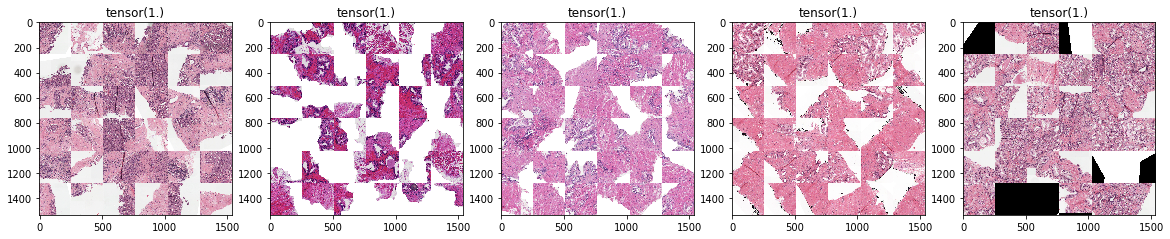

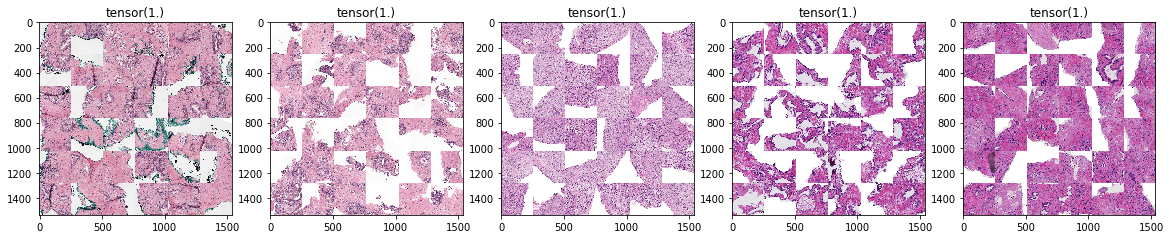

In [9]:
tsfm = data_transform()
dataset_show = PandaPatchDataset(csv_file, image_folder, image_size, N = n_tiles, transform=tsfm, rand = True)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]['img'], dataset_show[idx]['isup_grade']
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [10]:
del dataset_show

In [11]:
model = Model(enet_type, out_dim=out_dim)
model = model.to(device)

In [12]:
dataset = PandaPatchDataset(csv_file, image_folder, 256, transform=tsfm, N = 36, rand=True)
## dataloader
crossValData = crossValDataloader(csv_file, dataset, batch_size)

In [17]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for batch in bar:
        data, target = batch['img'], batch['isup_grade']
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        logits = logits['out']
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []
    acc = 0.
    n = 0
    with torch.no_grad():
        for batch in tqdm(loader):
            data, target = batch['img'], batch['isup_grade']
            data, target = data.to(device), target.to(device)
            logits = model(data)
            logits = logits['out']
            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            acc += (target.sum(1) == pred).sum().cpu().numpy()
            val_loss.append(loss.detach().cpu().numpy())
            n += 1

        val_loss = np.mean(val_loss)
        acc = acc / n * 100
    
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
#     qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
#     qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
#     print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [ ]:
for fold in range(1):
    trainloader, valloader = crossValData(fold)
    qwk_max = 0.
    best_file = f'{kernel_type}_best_fold{fold}.pth'
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler.step(epoch-1)

        train_loss = train_epoch(trainloader, optimizer)
        val_loss, acc, qwk = val_epoch(valloader)

        content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
        print(content)
        with open(f'log_{kernel_type}.txt', 'a') as appender:
            appender.write(content + '\n')

        if qwk > qwk_max:
            print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
            torch.save(model.state_dict(), best_file)
            qwk_max = qwk

    torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Wed Jun  3 02:16:38 2020 Epoch: 1



Wed Jun  3 02:36:22 2020 Epoch 1, lr: 0.0000300, train loss: 0.00052, val loss: 0.00172, acc: 200.00000, qwk: nan
Wed Jun  3 02:36:22 2020 Epoch: 2



Wed Jun  3 02:55:54 2020 Epoch 2, lr: 0.0000000, train loss: 0.00013, val loss: 0.00243, acc: 200.00000, qwk: nan
Wed Jun  3 02:55:54 2020 Epoch: 3
